In [1]:
def get_atomic_model_mask_strict(emmap_path, pdb_path, dilation_radius=3, softening_parameter=5, output_filename=None, save_files = True):
    '''
    Function to extract map intensities around atoms between a given residue range

    Parameters
    ----------
    emmap_path : str
        Path to a reference emmap for metadata
    pdb_path : str
        Path to a PDB/MMCIF file
  
    dilation_radius : float, optional
        The radius of the sphere (in Ang) to place at atomic positions determined by the PDB file. Default is 3A.

    Returns
    -------
    model_mask : str
    

    '''
    from locscale.include.emmer.pdb.pdb_tools import get_atomic_positions_between_residues
    from locscale.include.emmer.ndimage.map_utils import convert_pdb_to_mrc_position, dilate_mask, save_as_mrc
    import mrcfile
    import os
    from locscale.include.emmer.ndimage.filter import get_cosine_mask
    
    pdb_folder = os.path.dirname(pdb_path)
    pdb_name = os.path.basename(pdb_path)
    apix = mrcfile.open(emmap_path).voxel_size.tolist()[0]
    emmap = mrcfile.open(emmap_path).data
    map_shape = emmap.shape
    
    
    gemmi_st = gemmi.read_structure(pdb_path)
    
    
    mask = np.zeros(map_shape)
    pdb_positions = []
    for model in gemmi_st:
        for chain in model:
            for res in chain:
                for atom in res:
                    pdb_positions.append(atom.pos.tolist())
                        
        
    #print("Found {} atom sites".format(len(pdb_positions)))
        
    mrc_position = convert_pdb_to_mrc_position(pdb_positions, apix)
    zz,yy,xx = zip(*mrc_position)
    mask[zz,yy,xx] = 1
        
    dilation_radius_int = round(dilation_radius / apix)
    dilated_mask = dilate_mask(mask, radius=dilation_radius_int)
    
    if softening_parameter > 1:
        softened_mask = get_cosine_mask(dilated_mask, length_cosine_mask_1d=softening_parameter)
    else:
        softened_mask = dilated_mask
    
    if save_files:
        if output_filename is None:
            output_filename = os.path.join(pdb_folder, pdb_name[:-4]+"_model_mask.mrc")
                
        save_as_mrc(softened_mask, output_filename=output_filename, apix=apix)
            
        return output_filename
    else:

        return softened_mask

In [2]:
# Script to check whether atomic mask and FDR mask give same number of atoms
from genericpath import isfile
import os
import sys
import shutil
import subprocess
import numpy as np
from datetime import datetime
from joblib import Parallel, delayed




EMDB_PDB_ids_training = ["0026_6gl7", "7573_6crv",  "0665_6oa9", "0038_6gml", "0071_6gve", "0093_6gyn", "0094_6gyo", "0132_6h3c", "0234_6hjn", "0408_6nbd", "0415_6nbq", "4288_6fo2", "0452_6nmi", "0490_6nr8", "0492_6nra", "0567_6o0h", "0589_6nmi", "0592_6o1m", "0776_6ku9", "10049_6rx4", "10069_6s01", "10100_6s5t", "10105_6s6t", "10106_6s6u", "10273_6sof", "10279_6sp2", "10324_6swe", "10333_6swy", "10418_6t9n", "10534_6tni", "10585_6ttu", "10595_6tut", "10617_6xt9", "20145_6oo4", "20146_6oo5", "20189_6osy", "20234_6p19", "20249_6p4h", "20254_6p5a", "20259_6p62", "20270_6p7v", "20271_6p7w", "20352_6pik", "20521_6pxm", "20986_6v0b", "21012_6v1i", "21107_6v8o", "21144_6vbu", "21391_6vv5", "3661_5no2", "3662_5no3", "3802_5of4", "3885_6el1", "3908_6eoj", "4032_5lc5", "4073_5lmn", "4074_5lmo", "4079_5lmt", "4148_5m3m", "4162_6ezo", "4192_6f6w", "4214_6fai", "4241_6fe8", "4272_6fki", "4401_6i2x", "4404_6i3m", "4429_6i84", "4588_6qm5", "4589_6qm6", "4593_6qma", "4728_6r5k", "4746_6r7x", "4759_6r8f", "4888_6ric", "4889_6rid", "4890_6rie", "4907_6rkd", "4917_6rla", "4918_6rlb", "4941_6rn3", "4983_6rqj", "7009_6ave", "7041_6b3q", "7065_6b7y", "7090_6bf6", "7334_6c23", "7335_6c24", "8911_6dt0", "8958_6e1n", "8960_6e1p", "9258_6muw", "9259_6mux", "9931_6k7g", "9934_6k7i", "9935_6k7j", "9939_6k7l", "9941_6k7m", "9695_6iok"]
EMDB_PDB_ids_validation = ["0193_6hcg", "0257_6hra", "0264_6hs7", "0499_6nsk", "10401_6t8h", "20449_6pqo", "20849_6uqk", "4611_6qp6", "4646_6qvb", "4733_6r69", "4789_6rb9", "7133_6bqv", "7882_6dg7", "8069_5i08", "9112_6mgv", "9298_6mzc", "9374_6nhv"]
EMDB_PDB_ids_epsilon = ["0282_6huo", "0311_6hz5", "0560_6nzu", "10365_6t23", "20220_6oxl", "20226_6p07", "3545_5mqf", "4141_5m1s", "4531_6qdw", "4571_6qk7", "4997_6rtc", "7127_6bpq",  "8702_5vkq", "9610_6adq"]
EMDB_PDB_ids_all = EMDB_PDB_ids_training + EMDB_PDB_ids_validation + EMDB_PDB_ids_epsilon

res_dict = {"0026" : 6.3, "0038" : 3.2, "0071" : 3.9, "0093" : 3.4, "0094" : 3.4, "0132" : 3.9, "0234" : 3.3, "0408" : 3.2, "0415" : 3.1, "4288" : 4.4, "0452" : 3.7, "0490" : 7.8, "0492" : 7.7, "0567" : 3.67, "0589" : 3.9, "0592" : 3.15, "0665" : 3.9, "0776" : 2.67, "10049" : 3.3, "10069" : 3.2, "10100" : 4.15, "10105" : 4.1, "10106" : 3.5, "10273" : 4.3, "10279" : 3.33, "10324" : 3.1, "10333" : 3.2, "10418" : 2.96, "10534" : 3.4, "10585" : 3.7, "10595" : 3.25, "10617" : 3.8, "20145" : 3.3, "20146" : 4.2, "20189" : 4.3, "20234" : 3.8, "20249" : 3.2, "20254" : 3.6, "20259" : 3.57, "20270" : 4, "20271" : 4.1, "20352" : 7.8, "20521" : 2.1, "20986" : 4.1, "21012" : 3.8, "21107" : 3.07, "21144" : 3.1, "21391" : 3.5, "3661" : 5.16, "3662" : 5.16, "3802" : 4.4, "3885" : 6.1, "3908" : 3.55, "4032" : 4.35, "4073" : 3.55, "4074" : 4.3, "4079" : 4.15, "4148" : 4, "4162" : 4.1, "4192" : 3.81, "4214" : 3.4, "4241" : 4.1, "4272" : 4.3, "4401" : 3.35, "4404" : 3.93, "4429" : 4.4, "4588" : 3.6, "4589" : 3.7, "4593" : 3.7, "4728" : 4.8, "4746" : 3.47, "4759" : 3.8, "4888" : 2.8, "4889" : 2.9, "4890" : 3.1, "4907" : 3.2, "4917" : 3.9, "4918" : 4.5, "4941" : 4, "4983" : 3.5, "7009" : 3.7, "7041" : 3.7, "7065" : 6.5, "7090" : 6.5, "7334" : 3.9, "7335" : 3.5, "8911" : 3.7, "8958" : 3.7, "8960" : 3.7, "9258" : 3.6, "9259" : 3.9, "9931" : 3.3, "9934" : 3.22, "9935" : 3.08, "9939" : 2.83, "9941" : 2.95, "9695" : 3.64, "0193" : 4.3, "0257" : 3.7, "0264" : 4.6, "0499" : 2.7, "10401" : 3.77, "20449" : 2.88, "20849" : 3.77, "4611" : 3.2, "4646" : 4.34, "4733" : 3.65, "4789" : 3.2, "7133" : 3.1, "7882" : 3.32, "8069" : 4.04, "9112" : 3.1, "9298" : 4.5, "9374" : 3.5, "0282" : 3.26, "0311" : 4.2, "0560" : 3.2, "10365" : 3.1, "20220" : 3.5, "20226" : 3.2, "3545" : 5.9, "4141" : 6.7, "4531" : 2.83, "4571" : 3.3, "4997" : 3.96, "7127" : 4.1, "7573" : 3.2, "8702" : 3.55, "9610" : 3.5}

symmetry_dictionary = {'0026': 'C2', '0038': 'C1', '0071': 'D2', '0093': 'C4', '0094': 'C4', '0132': 'C2', '0234': 'C3', '0408': 'C2', '0415': 'C1', '4288': 'C2', '0452': 'C1', '0490': 'C1', '0492': 'C1', '0567': 'D2', '0589': 'C1', '0592': 'C2', '0665': 'C1', '0776': 'C3', '10049': 'C1', '10069': 'C1', '10100': 'C1', '10105': 'C1', '10106': 'C2', '10273': 'C1', '10279': 'C6', '10324': 'C1', '10333': 'C1', '10418': 'C4', '10534': 'C1', '10585': 'C1', '10595': 'C1', '10617': 'C1', '20145': 'C2', '20146': 'C2', '20189': 'C3', '20234': 'C1', '20249': 'C1', '20254': 'C2', '20259': 'C3', '20270': 'C1', '20271': 'C1', '20352': 'C2', '20521': 'O', '20986': 'C5', '21012': 'C9', '21107': 'C1', '21144': 'C1', '21391': 'C3', '3661': 'C1', '3662': 'C1', '3802': 'C1', '3885': 'C10', '3908': 'C1', '4032': 'C1', '4073': 'C1', '4074': 'C1', '4079': 'C1', '4148': 'C1', '4162': 'C2', '4192': 'C1', '4214': 'C1', '4241': 'C1', '4272': 'C1', '4401': 'C1', '4404': 'C2', '4429': 'C1', '4588': 'C2', '4589': 'C2', '4593': 'C2', '4728': 'C1', '4746': 'C2', '4759': 'C1', '4888': 'C1', '4889': 'C1', '4890': 'C1', '4907': 'D3', '4917': 'C2', '4918': 'C1', '4941': 'C1', '4983': 'C1', '7009': 'C3', '7041': 'C1', '7065': 'C1', '7090': 'C2', '7334': 'C1', '7335': 'C1', '8911': 'C2', '8958': 'C2', '8960': 'C2', '9258': 'C2', '9259': 'C1', '9931': 'C1', '9934': 'C1', '9935': 'C1', '9939': 'C1', '9941': 'C1', '9695': 'C1', '0193': 'C15', '0257': 'C1', '0264': 'C5', '0499': 'C6', '10401': 'C1', '20449': 'C4', '20849': 'C4', '4611': 'C2', '4646': 'C2', '4733': 'C1', '4789': 'C7', '7133': 'C4', '7882': 'C5', '8069': 'C3', '9112': 'C2', '9298': 'C1', '9374': 'C1', '0282': 'C1', '0311': 'C2', '0560': 'C2', '10365': 'C1', '20220': 'C1', '20226': 'C1', '3545': 'C1', '4141': 'C1', '4531': 'C1', '4571': 'C1', '4997': 'C2', '7127': 'C4', '7573': 'C3', '8702': 'C4', '9610': 'C2'}


local_copy_folder = "/home/abharadwaj1/papers/elife_paper/figure_information/data/locscale_MF_version_C"

# Copy all the files to a local folder for easy access
input_files_local = {}
num_emdb_present = 0
for emdb_pdb in os.listdir(local_copy_folder):
    local_emdb_folder = os.path.join(local_copy_folder, emdb_pdb)
    if not os.path.isdir(local_emdb_folder):
        continue
    input_files_local[emdb_pdb] = {}
    for file in os.listdir(local_emdb_folder):
        if file.endswith(".pdb"):
            if "shifted_bfactors" in file:
                input_files_local[emdb_pdb]["target_shifted_pdb_path"] = os.path.join(local_emdb_folder, file)
            else:
                input_files_local[emdb_pdb]["target_pdb_path"] = os.path.join(local_emdb_folder, file)
        
        if "unsharpened" in file:
            input_files_local[emdb_pdb]["unsharpened_map_path"] = os.path.join(local_emdb_folder, file)
        
        if "confidence" in file:
            input_files_local[emdb_pdb]["mask_path"] = os.path.join(local_emdb_folder, file)
        
        if "locscale" in file and file.endswith(".mrc"):
            input_files_local[emdb_pdb]["locscale_path"] = os.path.join(local_emdb_folder, file)
        
    # check if all the files are present
    if len(input_files_local[emdb_pdb]) == 5:
        #print("All files are present for {}".format(emdb_pdb))
        num_emdb_present += 1
    else:
        print("Not all files are present for {}".format(emdb_pdb))

print("Number of EMDBs with all files present: {}".format(num_emdb_present))
print("Number of EMDBs with some files missing: {}".format(len(input_files_local) - num_emdb_present))




Number of EMDBs with all files present: 120
Number of EMDBs with some files missing: 0


In [3]:
atomic_model_path_parent_folder = "/home/abharadwaj1/papers/elife_paper/figure_information/data/deposited_atomic_models"
confidence_mask_path_parent_folder = "/home/abharadwaj1/papers/elife_paper/figure_information/data/confidence_masks"
atomic_model_paths = {}
mask_paths = {}
for emdb_pdb in EMDB_PDB_ids_all:
    emdb, pdb = emdb_pdb.split("_")

    pdb_path = os.path.join(atomic_model_path_parent_folder, f"PDB_{pdb}_unrefined_shifted_servalcat_refined_shifted_servalcat_refined.pdb")    
    mask_path = os.path.join(confidence_mask_path_parent_folder, f"emd_{emdb}_FDR_confidence_final.map")

    if os.path.exists(mask_path) and os.path.exists(pdb_path):
        mask_paths[emdb_pdb] = mask_path
        atomic_model_paths[emdb_pdb] = pdb_path
    else:
        print(f"Could not find files for {emdb_pdb}")
        print(os.path.exists(mask_path), os.path.exists(pdb_path))

Could not find files for 4907_6rkd
False False
Could not find files for 8911_6dt0
False False
Could not find files for 20449_6pqo
False False


In [4]:
from locscale.include.emmer.ndimage.map_tools import get_atomic_model_mask
from tqdm import tqdm
import os
import gemmi

atomic_model_mask_parent_folder = "/home/abharadwaj1/dev/data/atomic_model_mask"
# if not os.path.isdir(atomic_model_mask_parent_folder):
#     os.mkdir(atomic_model_mask_parent_folder)

# for emdb_pdb in tqdm(input_files_local):   
#     target_pdb_path = atomic_model_paths[emdb_pdb]
#     emmap_path = input_files_local[emdb_pdb]["unsharpened_map_path"]
#     # get the atomic model mask
#     atomic_model_mask_path_emdb = os.path.join(atomic_model_mask_parent_folder, f"atomic_model_mask_{emdb_pdb}_strict_3A.mrc")
#     get_atomic_model_mask_strict(emmap_path, target_pdb_path, dilation_radius=1.5, softening_parameter=0, output_filename=atomic_model_mask_path_emdb, save_files=True)
    

In [5]:
# add hydrogens to the atomic model
import subprocess
folder_to_save_hydrogenated_models = "/home/abharadwaj1/papers/elife_paper/figure_information/data/atomic_models_with_hydrogen"
# for emdb_pdb in input_files_local:
#     target_pdb_path = atomic_model_paths[emdb_pdb]
#     target_pdb_path_hydrogenated = os.path.join(folder_to_save_hydrogenated_models, f"{emdb_pdb}_hydrogenated_model.pdb")
#     subprocess.run(["gemmi","h",target_pdb_path, target_pdb_path_hydrogenated])
    

In [6]:
from locscale.include.emmer.pdb.pdb_to_map import detect_pdb_input
from locscale.include.emmer.pdb.pdb_utils import get_coordinates 
from locscale.include.emmer.ndimage.map_utils import convert_pdb_to_mrc_position, load_map
def convert_pdb_to_point_map(input_pdb, apix, mask_shape):
    pdb_positions = get_coordinates(input_pdb)
    mrc_positions = convert_pdb_to_mrc_position(pdb_positions, apix)
    mrc_positions = np.array(mrc_positions)
    print(mrc_positions.shape)
    unique_mrc_positions = np.unique(mrc_positions, axis=0)
    print("unique_mrc_positions", unique_mrc_positions.shape)
    # remove the positions that are outside the map
    # mrc_positions = mrc_positions[(mrc_positions[:,0] < mask_shape[0]) & (mrc_positions[:,1] < mask_shape[1]) & (mrc_positions[:,2] < mask_shape[2])]
    atomic_point_map = np.zeros(mask_shape)
    atomic_point_map[unique_mrc_positions[:,0], unique_mrc_positions[:,1], unique_mrc_positions[:,2]] = 1    
    print(np.sum(atomic_point_map))
    return atomic_point_map





In [7]:
sample_emdb_pdb = "0038_6gml"
sample_pdb_path = atomic_model_paths[sample_emdb_pdb]
sample_atomic_model_mask_path = os.path.join(atomic_model_mask_parent_folder, f"atomic_model_mask_{sample_emdb_pdb}_strict_3A.mrc")
sample_atomic_model_mask, apix = load_map(sample_atomic_model_mask_path)
sample_point_map = convert_pdb_to_point_map(sample_pdb_path, apix, sample_atomic_model_mask.shape)




(44827, 3)
unique_mrc_positions (43968, 3)
43968.0


In [8]:
from locscale.include.emmer.ndimage.map_utils import read_gemmi_map

sample_model_mask_gemmi_map, grid = read_gemmi_map(sample_atomic_model_mask_path, return_grid=True)
st_sample = gemmi.read_structure(sample_pdb_path)

interpolated_values = []
for cra in st_sample[0].all():
    atom = cra.atom
    interpolated_values.append(grid.interpolate_value(atom.pos))

interpolated_values = np.array(interpolated_values)
print(np.sum(interpolated_values))

44827.0


In [9]:
atom.element.weight

12.0107

In [10]:
sample_pseudo_model_path = input_files_local[sample_emdb_pdb]["target_pdb_path"]

st_sample_pseudo = gemmi.read_structure(sample_pseudo_model_path)

num_atoms_included = 0 
for cra in st_sample_pseudo[0].all():
    atom = cra.atom
    atom_inclusion_intensity = grid.interpolate_value(atom.pos)
    if atom_inclusion_intensity > 0.5:
        num_atoms_included += 1
    
print(num_atoms_included)


60685


In [11]:
def get_number_of_atoms_included_in_mask(pdb_path, mask_path):
    st = gemmi.read_structure(pdb_path)
    mask, grid = read_gemmi_map(mask_path, return_grid=True)
    num_atoms_included = 0

    for cra in st[0].all():
        atom = cra.atom
        atom_inclusion_intensity = grid.interpolate_value(atom.pos)
        if atom_inclusion_intensity > 0.5:
            num_atoms_included += 1
    
    return num_atoms_included

In [12]:

num_atoms_pdb = {}
num_atoms_pdb_hydr = {}
num_atoms_in_pseudomodel_within_atomic_mask = {}
num_atoms_in_atomic_model_within_atomic_mask = {}

count = 0
protein_density_ideal = {}
for emdb_pdb in input_files_local:
    atomic_mask_path = os.path.join(atomic_model_mask_parent_folder, f"atomic_model_mask_{emdb_pdb}_strict_3A.mrc")
    atomic_mask, apix = load_map(atomic_mask_path)

    atomic_mask = (atomic_mask > 0.5).astype(np.int)

    # Get the number of atoms in the pdb
    pdb_path = atomic_model_paths[emdb_pdb]
    pdb_path_hydr = os.path.join(folder_to_save_hydrogenated_models, f"{emdb_pdb}_hydrogenated_model.pdb")

    st = detect_pdb_input(pdb_path)
    num_atoms_pdb[emdb_pdb] = st[0].count_atom_sites()

    st_hydr = detect_pdb_input(pdb_path_hydr)
    num_atoms_pdb_hydr[emdb_pdb] = st_hydr[0].count_atom_sites()

    # Convert the pseudomodel to a point map
    pseudomodel_path = input_files_local[emdb_pdb]["target_pdb_path"]
    
    # Get the number of atoms in the pseudomodel within the atomic mask
    num_atoms_in_pseudomodel_within_atomic_mask[emdb_pdb] = get_number_of_atoms_included_in_mask(pseudomodel_path, atomic_mask_path)
    num_atoms_in_atomic_model_within_atomic_mask[emdb_pdb] = get_number_of_atoms_included_in_mask(pdb_path, atomic_mask_path)

    mass_of_protein = st[0].calculate_mass()
    volume_of_mask = np.sum(atomic_mask) * apix**3
    density = mass_of_protein / volume_of_mask # in dalton / angstrom^3
    protein_density_ideal[emdb_pdb] = density * 1.66054 # in g / cc
    count += 1
    
    factor = num_atoms_in_pseudomodel_within_atomic_mask[emdb_pdb] / num_atoms_in_atomic_model_within_atomic_mask[emdb_pdb]
    print(count, emdb_pdb, num_atoms_pdb[emdb_pdb], num_atoms_in_pseudomodel_within_atomic_mask[emdb_pdb], num_atoms_in_atomic_model_within_atomic_mask[emdb_pdb], factor, protein_density_ideal[emdb_pdb])




1 0026_6gl7 13506 31910 13506 2.362653635421294 0.8642253064445647
2 7573_6crv 21036 34204 21036 1.6259745198706979 0.8714991579844547
3 0665_6oa9 29006 50324 29006 1.734951389367717 0.9575567859951281
4 0038_6gml 44827 60685 44827 1.3537600107078323 1.0933035069429633
5 0071_6gve 33412 56554 33412 1.6926254040464503 0.8982112431815595
6 0093_6gyn 16932 17112 16932 1.0106307583274274 0.9882301825607454
7 0094_6gyo 17540 22210 17540 1.266248574686431 0.9981044674140384
8 0132_6h3c 25122 31529 25122 1.2550354271156754 1.038117919724553
9 0408_6nbd 4472 5033 4472 1.1254472271914133 0.9961392196240513
10 0415_6nbq 28296 36056 28296 1.274243709358213 0.9154983133709861
11 4288_6fo2 30549 51852 30549 1.6973387017578316 0.8547543225386418
12 0452_6nmi 24379 35372 24379 1.4509208745231552 0.7947906007671163
13 0490_6nr8 68284 112167 68284 1.6426542088922735 0.8549929653668521
14 0492_6nra 62802 141728 62802 2.2567434158147828 0.8533248618370813
15 0567_6o0h 32012 45162 32012 1.4107834562039234

In [14]:
number_of_hyrdo_atoms = 0
number_of_carbon_atoms = 0
for cra in st_hydr[0].all():
    atom = cra.atom
    if atom.element.name == "H":
        number_of_hyrdo_atoms += 1
    if atom.element.name == "C":
        number_of_carbon_atoms += 1

print(number_of_hyrdo_atoms, number_of_carbon_atoms)


49506 32318


In [15]:
49506/32318

1.5318398415743548

In [16]:

from locscale.include.emmer.ndimage.map_tools import compute_real_space_correlation as rsc
import pypdb
import time
count = 0
molecular_weight_sequence = {}
molecular_weight_fdr = {}
rscc_mask = {}
protein_density_assumed = 1.35 # g / cc
protein_density_assumed_in_dalton_per_angstrom3 = protein_density_assumed / 1.66054
for emdb_pdb in input_files_local:
    try: 
        atomic_mask_path = os.path.join(atomic_model_mask_parent_folder, f"atomic_model_mask_{emdb_pdb}_strict_3A.mrc")
        atomic_mask, apix = load_map(atomic_mask_path)

        atomic_mask = (atomic_mask > 0.5).astype(np.int)

        # get the sequence weight
        seq_info = pypdb.get_all_info(emdb_pdb.split("_")[1])
        sequence_weight = seq_info['rcsb_entry_info']['molecular_weight'] # in kilodalton
        molecular_weight_sequence[emdb_pdb] = sequence_weight * 1000 # in dalton

        fdr_confidence_mask_path = mask_paths[emdb_pdb]
        fdr_confidence_mask = load_map(fdr_confidence_mask_path)[0]

        fdr_confidence_mask = (fdr_confidence_mask >= 0.99).astype(np.int)

        # measure the rscc between the atomic mask and the fdr confidence mask
        rscc = rsc(atomic_mask, fdr_confidence_mask)

        rscc_mask[emdb_pdb] = rscc
        

        # Get the molecular weight of the fdr confidence mask
        fdr_confience_mask_volume = np.sum(fdr_confidence_mask) * apix**3 # in angstrom^3
        molecular_weight_fdr[emdb_pdb] = fdr_confience_mask_volume * protein_density_assumed_in_dalton_per_angstrom3 # in dalton
        
        mol_weight_seq_kDa = molecular_weight_sequence[emdb_pdb] / 1000
        mol_weight_fdr_kDa = molecular_weight_fdr[emdb_pdb] / 1000
        print(count, emdb_pdb, mol_weight_seq_kDa, mol_weight_fdr_kDa, rscc_mask[emdb_pdb])
        count += 1
    except:
        print(f"Failed for {emdb_pdb}")
        # sleep 
        time.sleep(5)


0 0026_6gl7 255.99 927.5306790045041 0.5439085674469639
1 7573_6crv 420.06 736.6472098586739 0.6741179156427484
2 0665_6oa9 649.33 1153.8522372419272 0.6394532523622193
3 0038_6gml 928.52 1577.966426980207 0.6399393551229855
4 0071_6gve 486.25 757.9685668772732 0.8839708017404212
5 0093_6gyn 271.46 530.1516980484155 0.5087592161028054
6 0094_6gyo 276.38 662.6720173458398 0.5491919210128207
7 0132_6h3c 458.08 619.4027300299562 0.7462806896549996
8 0408_6nbd 63.37 73.26766033762749 0.8291784314692284
9 0415_6nbq 449.87 647.2671205002774 0.7835914975918644
10 4288_6fo2 506.81 1153.3572140375804 0.6450419342392677
11 0452_6nmi 389.39 494.15863268314354 0.8443967975222023
12 0490_6nr8 981.46 1617.4807716150985 0.8493213786247613
13 0492_6nra 903.01 2260.5371821577646 0.7516250086733924
14 0567_6o0h 494.67 680.9244043214535 0.8562648132975149
15 0589_6nmi 389.39 506.44403713980336 0.8470383739403271
16 0592_6o1m 224.35 331.5899727136909 0.8133221845437242
17 0776_6ku9 236.79 248.914852934635

/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/pypdb/util/http_requests.py:61: UserWarning: Too many failures on requests. Exiting...
  warnings.warn("Too many failures on requests. Exiting...")


Failed for 4401_6i2x
62 4404_6i3m 838.13 1234.2546539399914 0.6984843400255915
63 4429_6i84 732.09 1437.0116869423043 0.7659108005837357
64 4588_6qm5 166.56 541.9102149442836 0.5482208631386847
65 4589_6qm6 166.4 564.139071419676 0.559287504348625
66 4593_6qma 166.56 302.92788935905935 0.6618276750659636
67 4728_6r5k 482.28 700.7784355077813 0.787647867092816
68 4746_6r7x 166.3 523.3962049437957 0.43138307449014845
69 4759_6r8f 290.69 604.2462464426712 0.714153165597769
70 4888_6ric 505.34 790.0082631239346 0.7757579733456038
71 4889_6rid 450.98 805.9444119770849 0.7443954795610452
72 4890_6rie 581.77 964.8382407637127 0.7939005014832741
73 4917_6rla 1034.07 1059.9228419568228 0.7958228053716125
74 4918_6rlb 1377.6 851.9364746366094 0.6835385375225201
75 4941_6rn3 582.03 929.595293441854 0.7589611838020565
76 4983_6rqj 225.8 420.5200688164421 0.7279699806272737
77 7009_6ave 181.57 412.5078257303121 0.4900922765878277
78 7041_6b3q 253.1 407.47640037611296 0.841637325992481
79 7065_6b7y 

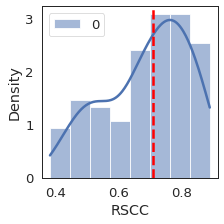

In [37]:
# Plot the distribution of RSCC 
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("white")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
figsize_cm = (8, 8)
figsize_inch = (figsize_cm[0] / 2.54, figsize_cm[1] / 2.54)
plt.figure(figsize=figsize_inch)
sns.histplot(rscc_mask.values(), kde=True, stat="density", bins=8)
# draw a vertical line at 0.71
plt.axvline(x=0.71, color="red", linestyle="--")
plt.xlabel("RSCC")
plt.ylabel("Density")
#plt.savefig("rscc_distribution.eps", dpi=600, bbox_inches="tight")
plt.show()



In [38]:
rssc_mask_values_list = list(rscc_mask.values())


rssc_mask_values_list

[0.5439085674469639,
 0.6741179156427484,
 0.6394532523622193,
 0.6399393551229855,
 0.8839708017404212,
 0.5087592161028054,
 0.5491919210128207,
 0.7462806896549996,
 0.8291784314692284,
 0.7835914975918644,
 0.6450419342392677,
 0.8443967975222023,
 0.8493213786247613,
 0.7516250086733924,
 0.8562648132975149,
 0.8470383739403271,
 0.8133221845437242,
 0.6784271917789536,
 0.5602101049902743,
 0.7160047229467031,
 0.8454805998559666,
 0.8121749076653465,
 0.8842335544872574,
 0.711039600540463,
 0.5466946462106358,
 0.7760738737737105,
 0.6900480850178159,
 0.4457592633698215,
 0.6572724616905518,
 0.7865574709189245,
 0.7694672763456245,
 0.786293843211579,
 0.5562208493979629,
 0.6485645402968666,
 0.7323519723973264,
 0.7262841671055331,
 0.789966391325541,
 0.7582552628121365,
 0.6347606082052552,
 0.7180211661001689,
 0.706195506063109,
 0.6779132708113588,
 0.8575228410878062,
 0.6556913014012247,
 0.6350866896128692,
 0.4155934805710223,
 0.8015335136559165,
 0.78186688115281

In [18]:
# Divide the RSCC into two classes such that the number of entries in each class is the same
# and print the mid point of the RSCC that divides the two classes
rscc_values = np.array(list(rscc_mask.values()))
rscc_values_sorted = np.sort(rscc_values)
rscc_values_sorted_midpoint = rscc_values_sorted[len(rscc_values_sorted) // 2]
print(rscc_values_sorted_midpoint)

0.714153165597769


In [19]:
def plot_correlations(x_array, y_array,  x_label, y_label, title_text, \
                    figsize_cm=(14,8),font="Helvetica",fontsize=10,\
                    fontscale=1,hue=None,find_correlation=True, alpha=0.3, filepath=None):

    import matplotlib.pyplot as plt
    from matplotlib.pyplot import cm
    from locscale.include.emmer.ndimage.profile_tools import crop_profile_between_frequency
    import seaborn as sns
    from scipy import stats
    import matplotlib 
    import pandas as pd
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    # set the global font size for the plot

        
    plt.rcParams.update({'font.size': fontsize})
    figsize = (figsize_cm[0]/2.54, figsize_cm[1]/2.54) # convert cm to inches
    
    fig = plt.figure(figsize=figsize, dpi=600) # dpi=600 for publication quality
    sns.set_theme(context="paper", font=font, font_scale=fontscale)
    # Set font size for all text in the figure
    sns.set_style("white")
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_facecolor('white')

    ax.plot(x_array, y_array, 'o', alpha=alpha)
    if find_correlation:
        slope, intercept, r_value, p_value, std_err = stats.linregress(x_array, y_array)
        ax.plot(x_array, intercept + slope*x_array, 'r')
        sign = "+" if intercept > 0 else "-"
        equation_text = f"y = {slope:.2f}x  {sign} {abs(intercept):.2f}"
        r_text = f"R = {r_value:.2f}"
        ax.text(0.05, 0.95, equation_text, transform=ax.transAxes, fontsize=fontsize, verticalalignment='top')
        ax.text(0.05, 0.9, r_text, transform=ax.transAxes, fontsize=fontsize, verticalalignment='top')

        
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.tight_layout()

    if filepath is not None:
        plt.savefig(filepath, bbox_inches='tight')

In [20]:
# dump the number of atoms results in a json file
import json 
from plot_utils import jsonify_dictionary
json_dump_directory = "/home/abharadwaj1/papers/elife_paper/figure_information/outputs/fdr_analysis_num_atoms"

num_atoms_results = {
    "num_atoms_in_pseudomodel_within_atomic_mask": num_atoms_in_pseudomodel_within_atomic_mask,
    "num_atoms_in_atomic_model" : num_atoms_pdb,
    "num_atoms_in_hydrogenated_atomic_model" : num_atoms_pdb_hydr,
}

json_file_path_num_atoms = os.path.join(json_dump_directory, "num_atoms_pdb_pseudomodel.json")

# with open(json_file_path_num_atoms, "w") as f:
#     json.dump(jsonify_dictionary(num_atoms_results), f, indent=4)

<Figure size 1889.76x1889.76 with 0 Axes>

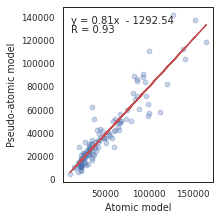

In [21]:
x_array_num_atoms_pdb = np.array(list(num_atoms_pdb_hydr.values()))
y_array_num_atoms_fdr = np.array(list(num_atoms_in_pseudomodel_within_atomic_mask.values()))

plot_correlations(x_array_num_atoms_pdb, y_array_num_atoms_fdr,  "Atomic model", "Pseudo-atomic model", "Number of atoms in PDB vs FDR confidence mask", \
                    figsize_cm=(8,8),font="Helvetica",fontsize=10,\
                    fontscale=1,hue=None,find_correlation=True, alpha=0.3)

In [22]:
# dump the molecular weight results and rscc mask results in a json file
json_file_path_mol_weight = os.path.join(json_dump_directory, "mol_weight_fdr_sequence.json")

mol_weight_results = {
    "molecular_weight_sequence": molecular_weight_sequence,
    "molecular_weight_fdr": molecular_weight_fdr,
    "rscc_mask": rscc_mask,
    "rscc_cutoff": 0.71,
}

# with open(json_file_path_mol_weight, "w") as f:
#     json.dump(jsonify_dictionary(mol_weight_results), f, indent=4)


<Figure size 1889.76x1889.76 with 0 Axes>

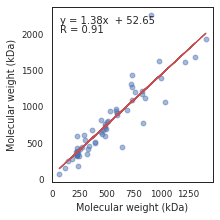

In [33]:
threshold_value_for_cutoff = 0.71
#rscc_threshold = (rscc_values.min(), threshold_value_for_cutoff)
rscc_threshold = (threshold_value_for_cutoff, rscc_values.max())
rscc_mask_filtered = {k: v for k, v in rscc_mask.items() if rscc_threshold[0] <= v < rscc_threshold[1]}
molecular_weight_sequence_filtered = {k: v/1000 for k, v in molecular_weight_sequence.items() if k in rscc_mask_filtered}
molecular_weight_fdr_filtered = {k: v/1000 for k, v in molecular_weight_fdr.items() if k in rscc_mask_filtered}

x_array = np.array(list(molecular_weight_sequence_filtered.values()))
y_array = np.array(list(molecular_weight_fdr_filtered.values()))

plot_correlations(x_array, y_array,  "Molecular weight (kDa)", "Molecular weight (kDa)", "Molecular weight (kDa)", \
                    figsize_cm=(8,8),font="Helvetica",fontsize=10,\
                    fontscale=1,hue=None,find_correlation=True, alpha=0.5) #filepath="molecular_weight_correlation_rscc_threshold_{:.2f}.eps".format(rscc_threshold[0])


In [ ]:
x_array_unfiltered = np.array(list(molecular_weight_sequence.values()))
y_array_unfiltered = np.array(list(molecular_weight_fdr.values()))

# plot_correlations(x_array_unfiltered, y_array_unfiltered,  "Molecular weight (kDa)", "Molecular weight (kDa)", "Molecular weight (kDa)", \
#                     scatter=True, figsize_cm=(8,8),font="Helvetica",fontsize=10,\
#                     fontscale=1,hue=None,find_correlation=True, alpha=0.3, filepath="molecular_weight_correlation_unfiltered.png")

plt.scatter(x_array_unfiltered, y_array_unfiltered)

In [ ]:
molecular_weight_fdr_filtered['7882_6dg7']

In [ ]:
# threshold the rscc
rscc_threshold = 0.8

# plot the scatter plot of the molecular weight of the sequence vs the molecular weight of the fdr confidence mask and display the r2
from sklearn.metrics import r2_score

molecular_weight_sequence_filtered = {}
molecular_weight_fdr_filtered = {}

emdb_pdb_filtered = [x for x in emdb_pdb if rscc_mask[x] >= rscc_threshold]
molecular_weight_sequence_filtered = {x: molecular_weight_sequence[x] for x in emdb_pdb_filtered}
molecular_weight_fdr_filtered = {x: molecular_weight_fdr[x] for x in emdb_pdb_filtered}




In [ ]:
# Draw a scatter plot showing the variation of the number of atoms in the pseudomodel within the atomic mask with the number of atoms in the atomic model

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set(context="paper", style="white", font_scale=1)
# set font to 8
plt.rcParams["font.size"] = 8

# set figure size to 8x8 cm
plt.rcParams["figure.figsize"] = (8, 8)

x = np.array(list(num_atoms_pdb.values()))
y = np.array(list(num_atoms_in_pseudomodel_within_atomic_mask.values()))

plt.scatter(x, y)
plt.xlabel("Atomic model")
plt.ylabel("Pseudo-atomic model")
plt.xlim(0, 100e3)
plt.ylim(0, 100e3)
plt.show()


In [ ]:
# get r_square 
from sklearn.metrics import r2_score

In [ ]:
# Draw a scatter plot with linear regression and plot the fit line with data

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

x = np.array(list(num_atoms_pdb.values()))
y = np.array(list(num_atoms_in_pseudomodel_within_atomic_mask.values()))

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(slope, intercept, r_value, p_value, std_err)

sns.set(context="paper", style="white", font_scale=1)
# set font to 12
plt.rcParams["font.size"] = 10
# Plot the fit line
plt.scatter(x, y)
# set figure size to 8x8 cm
figsize_cm = (10, 10)
figsize_inch = (figsize_cm[0] / 2.54, figsize_cm[1] / 2.54)
plt.rcParams["figure.figsize"] = figsize_inch
equation = f"y = {slope:.2f}x + {intercept:.2f}"
plt.plot(x, slope*x + intercept, 'r')
plt.text(0.3, 0.1, equation, transform=plt.gca().transAxes)
# plot r2_value 
#plt.text(0.3, 0.05, f"R = {r_value:.2f}", transform=plt.gca().transAxes)
y_data = y
y_pred = slope*x + intercept
r2 = r2_score(y_data, y_pred)
plt.text(0.3, 0.05, f"R$^2$ = {r2:.2f}", transform=plt.gca().transAxes)
plt.xlabel("Atomic model")
plt.ylabel("Pseudo-atomic model")
plt.xlim(0, 100e3)
plt.ylim(0, 100e3)
plt.tight_layout()
plt.savefig("pseudo-atomic_model_vs_atomic_model.png", dpi=600, bbox_inches="tight")



In [ ]:
import seaborn as sns

percentage_difference = (y - x) / x * 100

sns.histplot(percentage_difference, stat="density", kde=True)
plt.xlabel("Percentage difference")
plt.ylabel("Density")
plt.show()


In [ ]:
y = np.array(list(num_atoms_in_pseudomodel_within_atomic_mask.values()))
x = np.array(list(num_atoms_pdb.values()))

factor_distribution = y / x

sns.histplot(factor_distribution, stat="density", kde=True)
plt.xlabel("Factor")
plt.ylabel("Density")
plt.show()



In [ ]:
print(np.mean(percentage_difference), np.std(percentage_difference))

In [ ]:
# Perform a sensitivity analysis to find the effect of assumed average atomic weight on estimated number of atoms given protein density

mean_average_atomic_weight = 13.14
std_average_atomic_weight = 0.2

average_atomic_weight_distribution = np.random.normal(mean_average_atomic_weight, std_average_atomic_weight, 1000)

protein_density = 1.35



In [ ]:
from scipy.constants import Avogadro

sample_mask_volume = atomic_mask.sum() * apix**3
sample_mask_mass = sample_mask_volume * protein_density
sample_num_moles_distribution = sample_mask_mass / average_atomic_weight_distribution

sample_num_atoms_distribution = sample_num_moles_distribution * Avogadro

sample_num_atoms_distribution_norm = sample_num_atoms_distribution / sample_num_atoms_distribution.mean()
sns.histplot(sample_num_atoms_distribution_norm, stat="density", kde=True)



In [ ]:
protein_density_distribution = np.random.normal(protein_density, 0.1, 1000)

sample_mask_volume = atomic_mask.sum() * apix**3
sample_mask_mass_distribution = sample_mask_volume * protein_density_distribution

sample_num_moles_distribution = sample_mask_mass_distribution / mean_average_atomic_weight

sample_num_atoms_distribution = sample_num_moles_distribution * Avogadro

sample_num_atoms_distribution_norm = sample_num_atoms_distribution / sample_num_atoms_distribution.mean()

sns.histplot(sample_num_atoms_distribution_norm, stat="density", kde=True)

In [ ]:
protein_density_ideal = {}
molecular_volume_samples = []
for emdb_pdb in input_files_local:
    atomic_mask_path = os.path.join(atomic_model_mask_parent_folder, f"atomic_model_mask_{emdb_pdb}_strict_3A.mrc")
    atomic_mask, apix = load_map(atomic_mask_path)
    atomic_mask = (atomic_mask > 0.99).astype(np.int)

    # Get the volume of the atomic mask
    atomic_mask_volume = atomic_mask.sum() * apix**3

    molecular_volume_samples.append(atomic_mask_volume)

    # Get the number of atoms in the atomic model
    pdb_path = atomic_model_paths[emdb_pdb]
    st = detect_pdb_input(pdb_path)

    molecular_weight = st[0].calculate_mass() # in daltons

    density = molecular_weight / atomic_mask_volume # in da / A^3
    density_g_per_cm3 = density * 1.66054 # in g / cm^3

    protein_density_ideal[emdb_pdb] = density_g_per_cm3

    print(emdb_pdb, density_g_per_cm3)



In [ ]:
molecular_volume_samples_array = np.array(molecular_volume_samples) * 1e-24 # in cm^3

molecular_mass_distribution = molecular_volume_samples_array * np.random.normal(protein_density, 0.05, len(molecular_volume_samples_array))
num_moles_distribution = molecular_mass_distribution / np.random.normal(mean_average_atomic_weight, std_average_atomic_weight, len(molecular_volume_samples_array))

num_atoms_distribution = num_moles_distribution * Avogadro

num_atoms_true = np.array(list(num_atoms_pdb.values()))




In [ ]:
np.random.normal(mean_average_atomic_weight, std_average_atomic_weight, len(molecular_volume_samples_array)).std()

In [ ]:
molecular_mass_assumed = molecular_volume_samples_array *  1.35
num_moles_assumed = molecular_mass_assumed / (13.14)

num_atoms_assumed = num_moles_assumed * Avogadro

sns.histplot(num_atoms_assumed / num_atoms_true, stat="density", kde=True)

In [ ]:
# Scatter plot of num_atoms_assumed vs num_atoms_true with linear regression and plot the fit line with data
x = num_atoms_true
y = num_atoms_assumed

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
equation = f"y = {slope:.2f}x + {intercept:.2f}"
plt.scatter(x, y)
plt.plot(x, slope*x + intercept, 'r')
plt.text(0.05, 0.9, equation, transform=plt.gca().transAxes)
# plot r_value
plt.text(0.05, 0.85, f"r_value = {r_value:.2f}", transform=plt.gca().transAxes)
plt.xlabel("True number of atoms")
plt.ylabel("Calculated number of atoms within 3A atomic mask")
plt.xlim(0, 100e3)
plt.ylim(0, 100e3)
plt.show()



In [ ]:
factor_distribution = num_atoms_distribution / num_atoms_true

sns.histplot(factor_distribution, stat="density", kde=True)

In [ ]:
# Measure "average" protein density from the atomic models
protein_density_ideal_model = {}
molecular_volume_samples = []
window_size = 4
for emdb_pdb in tqdm(input_files_local):
    atomic_model_path = os.path.join(folder_to_save_hydrogenated_models, f"{emdb_pdb}_hydrogenated_model.pdb")
    st = detect_pdb_input(atomic_model_path)

    ns = gemmi.NeighborSearch(st[0], st.cell, window_size).populate()

    pdb_coordinates = [cra.atom.pos for cra in st[0].all()]

    random_sample = np.random.choice(pdb_coordinates, 500)

    density_samples = []
    for coord in random_sample:
        neigbors = ns.find_atoms(coord, '\0', window_size)
        atoms = [x.to_cra(st[0]).atom for x in neigbors]
        atomic_weights_neigbors = [atom.element.weight for atom in atoms]
        sum_of_atomic_weights = sum(atomic_weights_neigbors)
        volume_of_mask = 4/3 * np.pi * window_size**3
        density = sum_of_atomic_weights / volume_of_mask
        density_samples.append(density)
    
    protein_density_ideal_model[emdb_pdb] = density_samples



In [ ]:
from scipy.stats import gaussian_kde

max_density_samples = max([max(protein_density_ideal_model[emdb_pdb]) for emdb_pdb in protein_density_ideal_model])
min_density_samples = min([min(protein_density_ideal_model[emdb_pdb]) for emdb_pdb in protein_density_ideal_model])

density_samples_list = []
mean_density_list = []
for emdb_pdb in protein_density_ideal_model:
    y = np.array(protein_density_ideal_model[emdb_pdb])
    x = np.linspace(min_density_samples, max_density_samples, 1000)
    density = gaussian_kde(y)

    density_samples_list.append(density(x))
    mean_density_list.append(np.mean(y))


# Plot the density samples for each protein as a curve on the same plot
print("Mean density of all proteins: ", np.mean(mean_density_list))
for density_samples in density_samples_list:
    plt.plot(x, density_samples, color="black", alpha=0.1)



In [ ]:
average_density_samples = np.mean(density_samples_list, axis=0)


In [ ]:
model_sample = st_sample[0]
volume_of_atoms = []
for cra in model_sample.all():
    atom = cra.atom
    atom_radius = cra.atom.element.vdw_r
    volume_of_atom = 4/3 * np.pi * atom_radius**3
    volume_of_atoms.append(volume_of_atom)



In [ ]:
molecular_weight = model_sample.calculate_mass() # in daltons
molecular_volume = sum(volume_of_atoms) # in A^3

density = molecular_weight / molecular_volume # in da / A^3
density_g_per_cm3 = density * 1.66054 # in g / cm^3

print("Density of the model: ", density_g_per_cm3)
print("Density in daltons per cubic angstrom: ", density)

In [ ]:
vander_waals_density_sample = []
covalent_density_sample = []
for emdb_pdb in tqdm(input_files_local):
    atomic_model_path = os.path.join(folder_to_save_hydrogenated_models, f"{emdb_pdb}_hydrogenated_model.pdb")
    st = detect_pdb_input(atomic_model_path)

    molecular_weight = st[0].calculate_mass() # in daltons
    vdw_volume_of_atoms = 0
    covalent_volume_of_atoms = 0
    for cra in st[0].all():
        atom = cra.atom
        atom_radius = cra.atom.element.vdw_r
        volume_of_atom = 4/3 * np.pi * atom_radius**3
        vdw_volume_of_atoms += volume_of_atom

        covalent_radius = cra.atom.element.covalent_r
        covalent_volume_of_atom = 4/3 * np.pi * covalent_radius**3
        covalent_volume_of_atoms += covalent_volume_of_atom
    
    vdw_molecular_volume = vdw_volume_of_atoms # in A^3
    covalent_molecular_volume = covalent_volume_of_atoms # in A^3

    vdw_density = molecular_weight / vdw_molecular_volume # in da / A^3
    covalent_density = molecular_weight / covalent_molecular_volume # in da / A^3

    vdw_density_g_per_cm3 = vdw_density * 1.66054 # in g / cm^3
    covalent_density_g_per_cm3 = covalent_density * 1.66054 # in g / cm^3

    vander_waals_density_sample.append(vdw_density_g_per_cm3)
    covalent_density_sample.append(covalent_density_g_per_cm3)



In [ ]:
sns.histplot(vander_waals_density_sample, stat="density", kde=True)


In [ ]:
sns.histplot(covalent_density_sample, stat="density", kde=True)


In [ ]:
fdr_data_folder = "/home/abharadwaj1/dev/data/local_resolutions/FDR_FSC"

emd_20521_fdr_fsc_path = os.path.join(fdr_data_folder, "emd_20521_half_map_1_localResolutions.mrc")
emd_4141_fdr_fsc_path = os.path.join(fdr_data_folder, "emd_4141_half_map_1_localResolutions.mrc")

emdb_pdb_20521 = "20521_6pxm"
emdb_pdb_4141 = "4141_5m1s"
os.path.join(atomic_model_mask_parent_folder, f"atomic_model_mask_{emdb_pdb}_strict_3A.mrc")
emd_20521_atomic_model_mask_path = os.path.join(atomic_model_mask_parent_folder, "atomic_model_mask_{}_strict_3A.mrc".format(emdb_pdb_20521))
emd_4141_atomic_model_mask_path = os.path.join(atomic_model_mask_parent_folder, "atomic_model_mask_{}_strict_3A.mrc".format(emdb_pdb_4141))

emd_20521_fsc_local, _ = load_map(emd_20521_fdr_fsc_path)
emd_4141_fsc_local, _ = load_map(emd_4141_fdr_fsc_path)

emd_20521_atomic_model_mask, apix_20521 = load_map(emd_20521_atomic_model_mask_path)
emd_4141_atomic_model_mask, apix_4141 = load_map(emd_4141_atomic_model_mask_path)



In [ ]:
atomic_mask_20521_binarised = (emd_20521_atomic_model_mask > 0.5).astype(bool)
atomic_mask_4141_binarised = (emd_4141_atomic_model_mask > 0.5).astype(bool)

emd_20521_fsc_masked = emd_20521_fsc_local[atomic_mask_20521_binarised]
emd_4141_fsc_masked = emd_4141_fsc_local[atomic_mask_4141_binarised]


In [ ]:
print("Mean FSC of EMDB 20521: ", np.mean(emd_20521_fsc_masked))
print("Mean FSC of EMDB 4141: ", np.mean(emd_4141_fsc_masked))

print("Median FSC of EMDB 20521: ", np.median(emd_20521_fsc_masked))
print("Median FSC of EMDB 4141: ", np.median(emd_4141_fsc_masked))

print("Standard deviation of FSC of EMDB 20521: ", np.std(emd_20521_fsc_masked))
print("Standard deviation of FSC of EMDB 4141: ", np.std(emd_4141_fsc_masked))
